In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 170
plt.style.use("seaborn")

import xgboost as xgb
from sklearn.model_selection import (
    train_test_split,
    KFold,
    GridSearchCV,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action="ignore", category=FutureWarning)


In [29]:
# read the dataset
df = pd.read_csv('./star_classification.csv')

# encode values for `class` column
df.replace({'class': {'GALAXY': 0, 'STAR': 1, 'QSO':2}}, inplace=True)

# remove all columns containing `ID` at the end
cleaned = df.drop(df.filter(regex='ID$').columns, axis=1)
# drop the date column
cleaned = cleaned.drop('MJD', axis=1)

# make the X and y varialbes
X = cleaned.drop('class', axis=1)
y = cleaned['class']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

## Basic KNN with 5-Fold CV

In [30]:
scaler = StandardScaler()
# standardize all columns
X_train_std = scaler.fit_transform(X_train)

# create KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# create 5-Fold CV
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Fit the model
results = cross_val_score(knn, X_train_std, y_train, cv=kfold, scoring='accuracy')

print(max(results))

0.9255714285714286


## Tuning the KNN Model

In [31]:
# hyper parameters for CV
hyper_params = {
    'n_neighbors': range(1, 10+1)
}

scaler = StandardScaler()
# standardize all columns
X_train_std = scaler.fit_transform(X_train)

# create KNN model
knn = KNeighborsClassifier()

# create 5-Fold CV
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Tune `knn` using grid search
grid_search = GridSearchCV(knn, hyper_params, cv=kfold, scoring='accuracy')
grid_results = grid_search.fit(X_train_std, y_train)

In [32]:
# get the best accuracy achieved
print("Best accuracy", grid_results.best_score_)
print("Best K value", grid_results.best_estimator_.get_params()['n_neighbors'])

Best accuracy 0.9271142857142858
Best K value 3


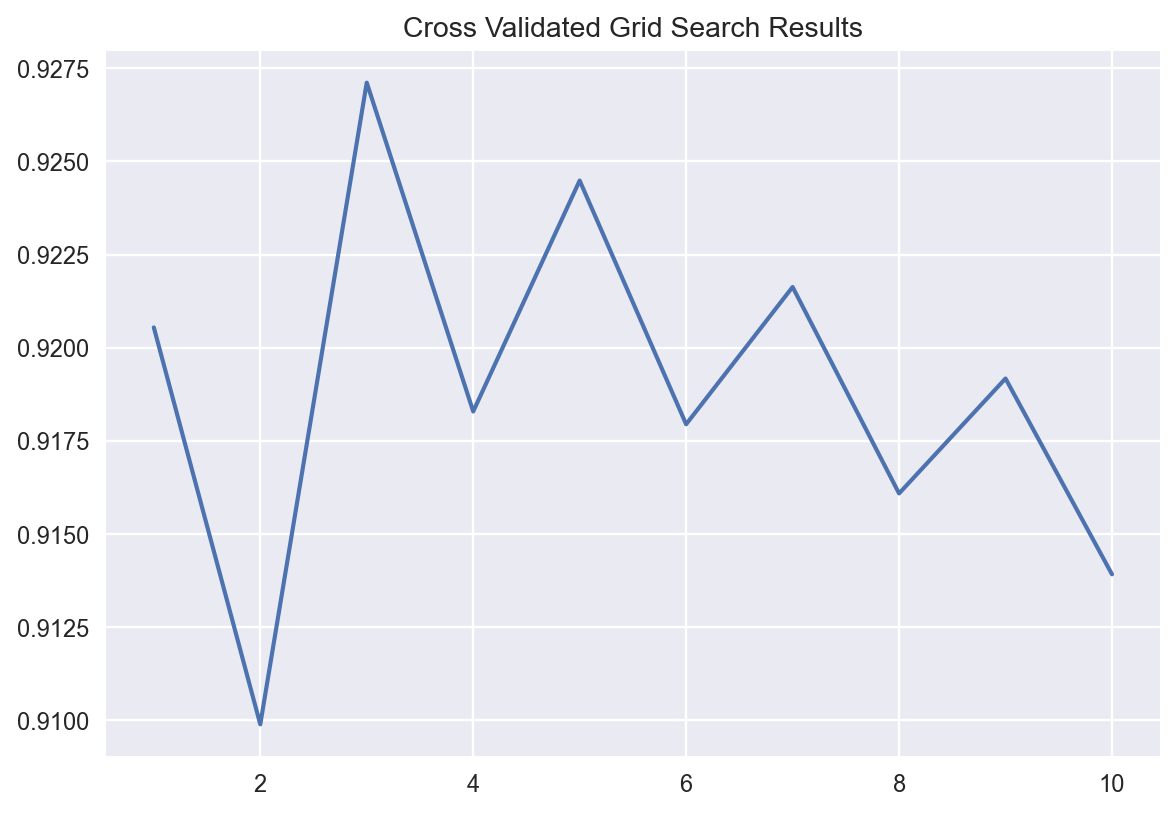

In [33]:
plt.plot(hyper_params['n_neighbors'], grid_search.cv_results_['mean_test_score'])
plt.title('Cross validated grid search results'.title())
plt.show()

### Feature Engineering

In [ ]:
%%capture

# fit the KNN with best K value
knn_best = KNeighborsClassifier(n_neighbors=3)
knn_best_fit = knn.fit(X_train_std, y_train)

r = permutation_importance(
    knn,
    X_train_std,
    y_train,
    n_repeats=5,
    random_state=123,
    n_jobs=-1,
)

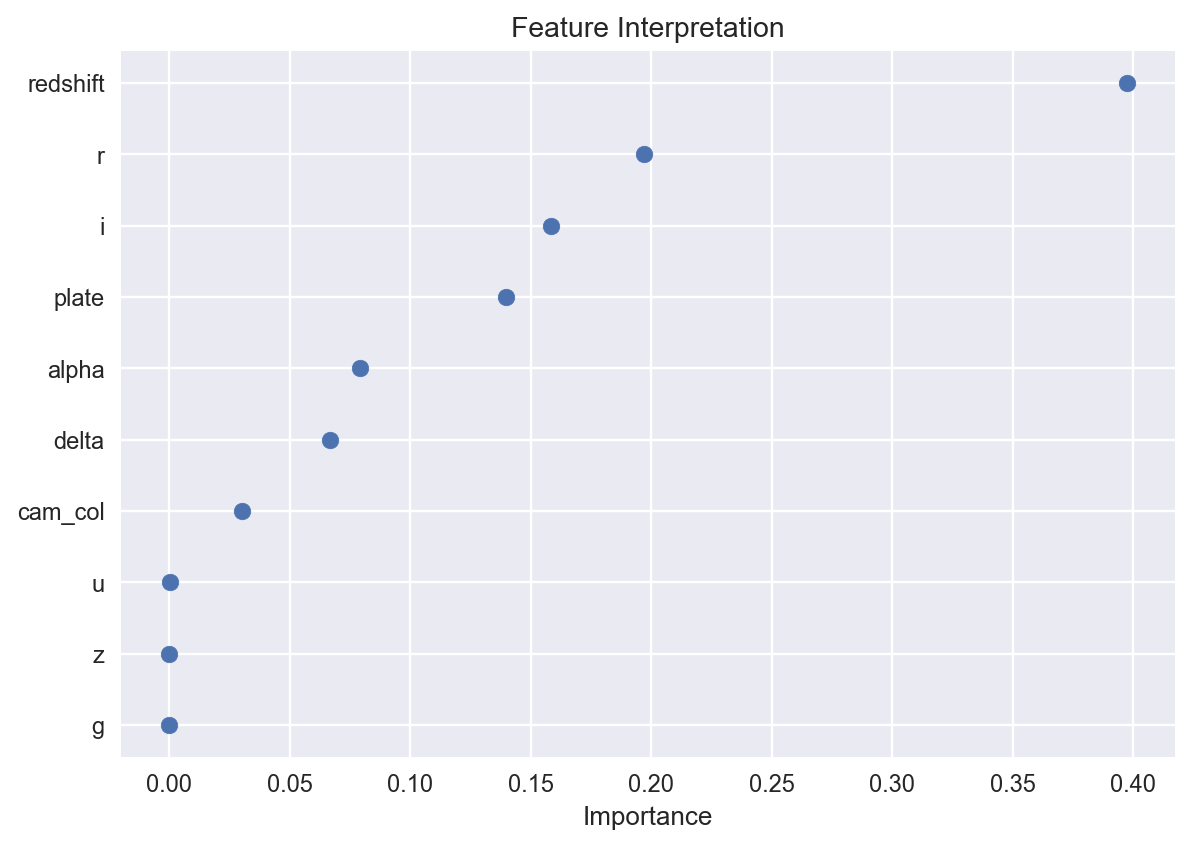

In [35]:
feat = pd.DataFrame({
    'feature': X_train.columns,
    'importance': r.importances_mean,
}).sort_values('importance')

plt.scatter(data=feat, x='importance', y='feature')
plt.xlabel("Importance")
plt.title('feature interpretation'.title())
plt.show()

## Basic Gradient Boosting Model

In [36]:
# create XGBClassifier model
xgb_model = xgb.XGBClassifier()

# create 5-Fold CV
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Fit the model
results = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='accuracy')

print(max(results))

0.9791428571428571


### With Randomized Searching

In [18]:
param_distributions = {
    'n_estimators': [1000, 2500, 5000],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 5, 15]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions,
    n_iter=5,
    cv=kfold,
    scoring='accuracy',
    random_state=123,
    n_jobs=-1,
)

search_results = random_search.fit(X_train_std, y_train)

In [21]:
search_results.best_score_

0.9789571428571427